In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_CBE_data(path, page=0):
    data = pd.read_excel(path, sheet_name=page)
    
    data = data[[
        "IP",
        "REGION",
        "DISTRICT",
        "COMMUNITY/CLASS",
        "TYPE OF OOSC",
        "SEX",
        "AGE",
        "DROP OUT (YES/NO)",
        "GRADUATED (YES/NO)",
        "TRANSITIONED (YES/NO)",
        "Language"]]
    
    data["DROP OUT (YES/NO)"] = data["DROP OUT (YES/NO)"].replace(["NO", "No"], "NO")
    data["DROP OUT (YES/NO)"] = data["DROP OUT (YES/NO)"].replace(["YES", "Yes"], "YES")
    
    data["TRANSITIONED (YES/NO)"] = data["TRANSITIONED (YES/NO)"].replace(["NO", "No"], "NO")
    data["TRANSITIONED (YES/NO)"] = data["TRANSITIONED (YES/NO)"].replace(["YES", "Yes"], "YES")
    
    return data

In [3]:
cycle_1 = read_CBE_data("shared_data_read_only/Data/AfriKids/InternalData/AfriKids_CBE_Data/AfriKids CBE Cycle 1 Learner Facilitator LC-SMC Training.xls", "Learner Data Template")
cycle_2 = read_CBE_data("shared_data_read_only/Data/AfriKids/InternalData/AfriKids_CBE_Data/AfriKids CBE Cycle 2 Learner Facilitator LC-SMC Training.xls", "Learner Data Template")
cycle_3 = read_CBE_data("shared_data_read_only/Data/AfriKids/InternalData/AfriKids_CBE_Data/AfriKids CBE Cycle 3 Learner Facilitator LC-SMC Training.xlsx", "Learner Data Template")
cycle_4 = read_CBE_data("shared_data_read_only/Data/AfriKids/InternalData/AfriKids_CBE_Data/AfriKids CBE Cycle 4 Learner Facilitator LC-SMC Training.xls", "Learner Data Template")
cycle_5 = read_CBE_data("shared_data_read_only/Data/AfriKids/InternalData/AfriKids_CBE_Data/Afrikids CBE Cycle 5  Learner Facilitator LC-SMC Training.xls")

In [4]:
all_results = pd.concat([cycle_1, cycle_2, cycle_3, cycle_4, cycle_5])

In [5]:
grouped = all_results.groupby(['REGION', 'DROP OUT (YES/NO)']).size().reset_index(name='counts')

pivot_table = grouped.pivot(index='REGION', columns='DROP OUT (YES/NO)', values='counts').fillna(0)

pivot_table['YES/NO Ratio'] = pivot_table['YES'] / pivot_table['NO']
pivot_table["Graduation Percentage"] = 100 - pivot_table['YES/NO Ratio'] * 100

print(pivot_table)

DROP OUT (YES/NO)     NO  YES  YES/NO Ratio  Graduation Percentage
REGION                                                            
Northern            4404   96      0.021798              97.820163
Upper East         11749  408      0.034726              96.527364


In [56]:
graduates = all_results[all_results["GRADUATED (YES/NO)"] == "YES"]

def compute_yes_percentage(series):
    yes_count = (series == 'YES').sum()
    total_count = series.notna().sum()
    percentage = (yes_count / total_count) * 100 if total_count > 0 else 0
    return percentage

graduated_percentages = all_results.groupby('REGION')['GRADUATED (YES/NO)'].apply(compute_yes_percentage)
transitioned_percentages = graduates.groupby('REGION')['TRANSITIONED (YES/NO)'].apply(compute_yes_percentage)

result = pd.DataFrame({
    'Graduated (%)': graduated_percentages,
    'Transitioned (%)': transitioned_percentages
})

In [63]:
result

,Graduated (%),Transitioned (%),Dropped out,Graduated,Transitioned
REGION,,,,,
Northern,65.266667,99.323867,34.733333,0.441289,64.825378
Upper East,43.653862,99.731423,56.346138,0.117244,43.536618


In [58]:
result['Dropped out'] = 100 - result['Graduated (%)']
result["Graduated"] = (1 - result['Transitioned (%)'] / 100) * result['Graduated (%)']
result["Transitioned"] = (result['Transitioned (%)'] / 100) * result['Graduated (%)']

<Axes: xlabel='REGION'>

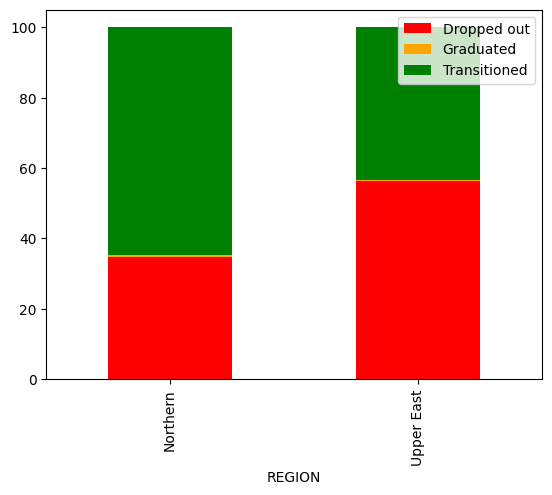

In [64]:
to_plot = result[["Dropped out", "Graduated", "Transitioned"]]

to_plot.plot(kind="bar", stacked=True, color=['red', 'orange', 'green'])